In [244]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, math

In [245]:
NUMBER_OF_CORES = 8

file2_scalable = pd.read_csv("openmp_sorting/results_scalable.txt")
file2_nonscalable = pd.read_csv("openmp_sorting/results_non-scalable.txt")
file3_scalable = pd.read_csv("openmp_sorting/results_merging_scalable.txt")
file3_nonscalable = pd.read_csv("openmp_sorting/results_merging_non-scalable.txt")

In [246]:
def plot(title, values, number_of_points, number_of_buckets, range_of_numbers, if_scalable):
    plt.scatter(np.arange(1, NUMBER_OF_CORES+1), y=values)
    plt.xticks(np.arange(1, NUMBER_OF_CORES+1))
    plt.xlabel("Number of cores")
    plt.ylabel(title)
    plt.title(title + " for " + str(number_of_points) + " points, " + if_scalable)
    plt.legend(["Number of buckets: " + str(number_of_buckets) + ",\n Range of numbers: " + str(range_of_numbers)])
    plt.show()

In [247]:
def plot_time(data_file, number_of_points, number_of_buckets, range_of_numbers, if_scalable):
    query = 'number_of_points==' + str(number_of_points) + ' & number_of_buckets==' + str(number_of_buckets) + ' & range_of_numbers==' + str(range_of_numbers)
    filtered_data = data_file.query(query)
    plot("Execution time (s)", filtered_data['time'].values, number_of_points, number_of_buckets, range_of_numbers, if_scalable)

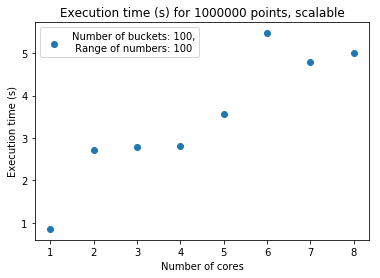

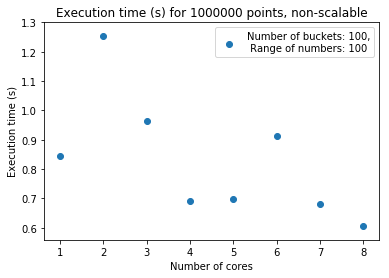

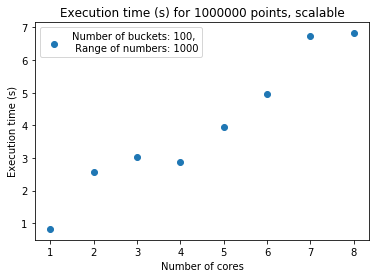

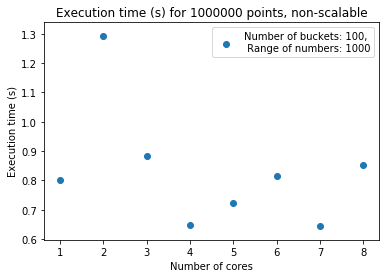

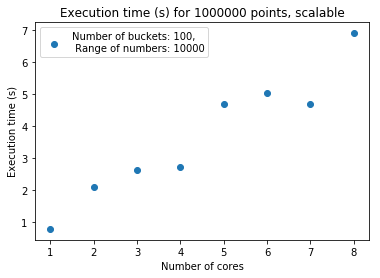

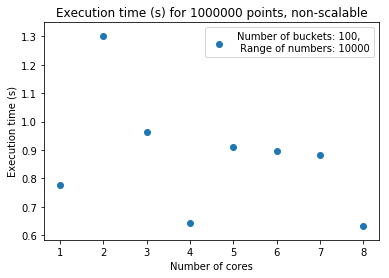

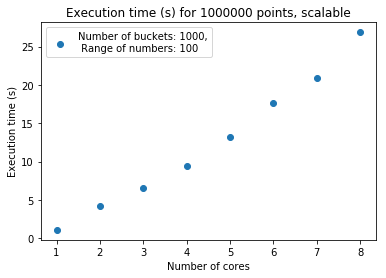

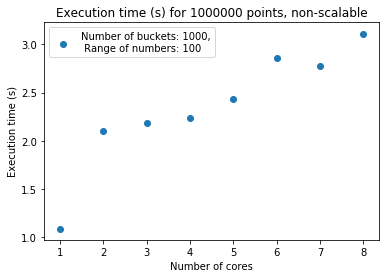

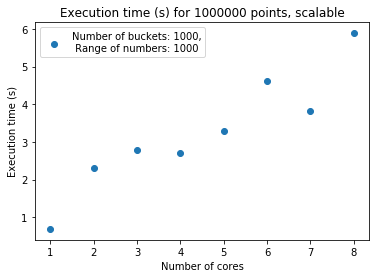

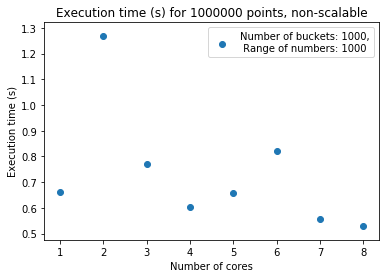

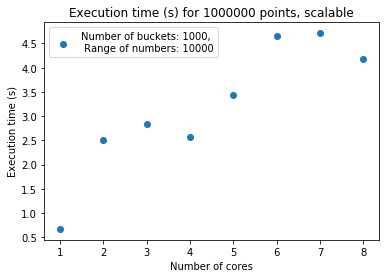

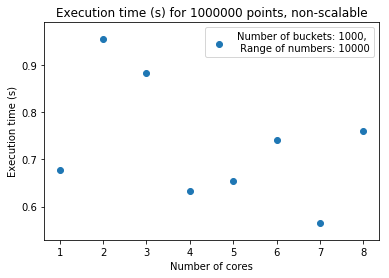

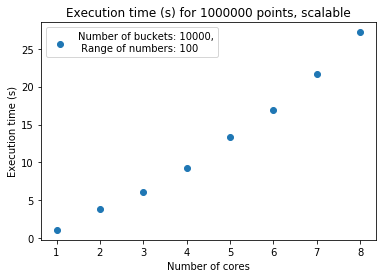

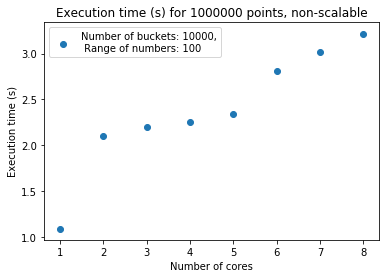

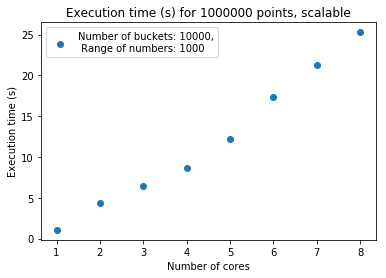

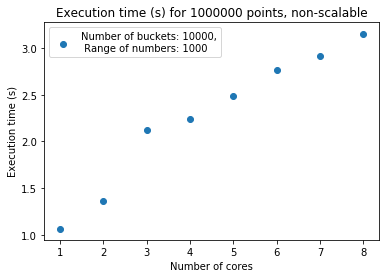

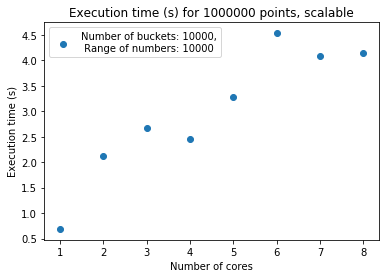

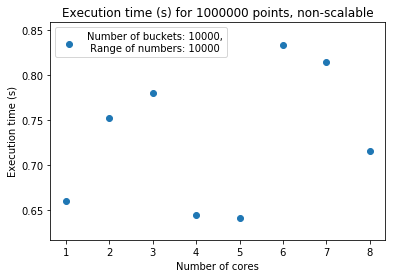

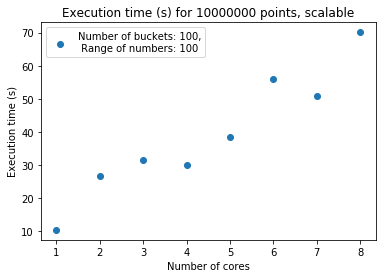

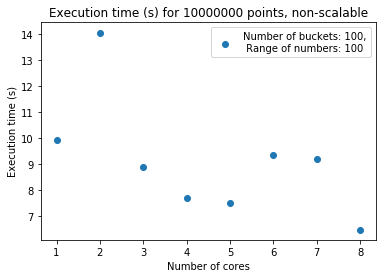

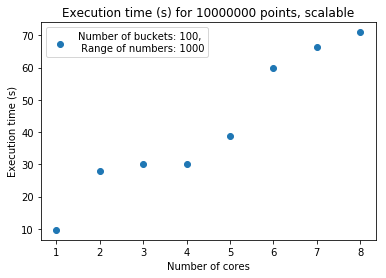

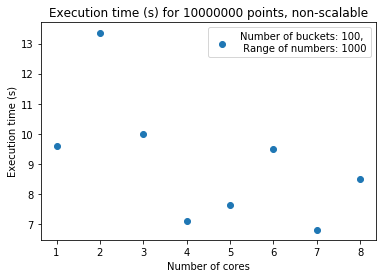

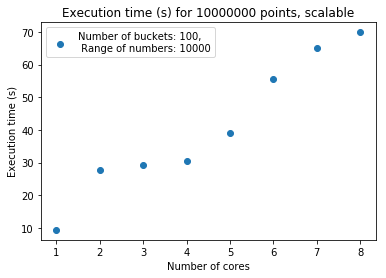

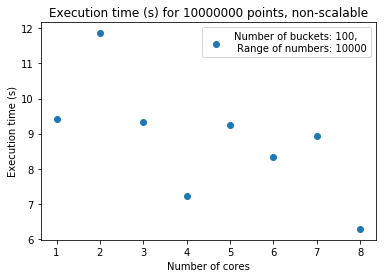

ValueError: x and y must be the same size

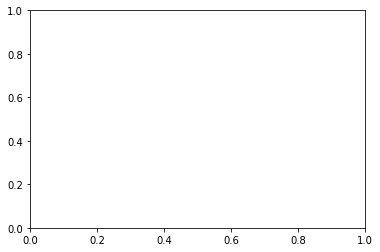

In [248]:
points = [1000000,10000000]
buckets = [100,1000,10000]
ranges = [100,1000,10000]

for p in points:
    for b in buckets:
        for r in ranges:
            plot_time(file2_scalable, p, b, r, "scalable")
            plot_time(file2_nonscalable, p, b, r, "non-scalable")
#             plot_time(file3_scalable, p, b, r, "scalable")
#             plot_time(file3_nonscalable, p, b, r, "non-scalable")

In [242]:
def speedup_scalable(sequence, time, cores):
    return (sequence / time) * cores

def speedup_nonscalable(sequence, time): 
    return sequence / time

In [243]:
def plot_speedup(data_file, number_of_points, number_of_buckets, range_of_numbers, if_scalable):
    query = 'number_of_points==' + str(number_of_points) + ' & number_of_buckets==' + str(number_of_buckets) + ' & range_of_numbers==' + str(range_of_numbers)
    filtered_data = data_file.query(query)
    
    times = filtered_data['time'].values
    sequence = times[0]
    speedup_values = []

    if if_scalable == "scalable":
        print("SKALOWALNY")
        for i in range (0, NUMBER_OF_CORES):
            speedup_values.append(speedup_scalable(sequence, times[i], i))
    else:
        for i in range (0, NUMBER_OF_CORES):
            speedup_values.append(speedup_nonscalable(sequence, times[i]))
            
    plot("Speedup", speedup_values, number_of_points, number_of_buckets, range_of_numbers, if_scalable)

In [ ]:
plot_speedup(file2_scalable,1000000,100,1000, "non-scalable")

In [ ]:
plot_time(file2_scalable,1000000,100,1000, "non-scalable")

In [ ]:
for p in points:
    for b in buckets:
        for r in ranges:
            plot_speedup(file2_scalable, p, b, r, "scalable")
            plot_speedup(file2_nonscalable, p, b, r, "non-scalable")
#             plot_speedup(file3_scalable, p, b, r, "scalable")
#             plot_speedup(file3_nonscalable, p, b, r, "non-scalable")

In [ ]:
Charts - TODO:
    algorytm 2 i 3 na tych samych wykresach - porównanie
    inne metryki ?